In [2]:
%load_ext autoreload
%autoreload 2

# get project dir
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

pp = PurePath(Path.cwd()).parts[:]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'

# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
# from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from utils import *
from bars import *
from labelling import *

RANDOM_STATE = 777

print()

In [6]:
def read_bbg_ticks(fp):
    df = (pd.read_csv(infp)
            .assign(dates = lambda raw_df: pd.to_datetime(raw_df['Unnamed: 0']))
            .assign(volume = lambda raw_df: raw_df['size'])
            .assign(price = lambda raw_df: raw_df['value'])
            .drop(['Unnamed: 0','type','size','value'],axis = 1)
            #.set_index('dates')
         )
    return df

In [16]:
# infp = PurePath(data_dir/'raw'/'12 HK Equity.csv')
# df = read_bbg_ticks(infp)


symbol_pair = 'BTCUSDT'
df = pd.read_csv(f'../binance-quant-AI/{symbol_pair}/{symbol_pair}-1m.csv')
df.columns=['ktime', 'open', 'high', 'low', 'close', 'volume', 'ctime', 'qvolume', 'trades_num', 'buy_volume', 'buy_qvolume', 'ignore']
df = df.loc[:, ['ktime', 'open', 'high', 'low', 'close', 'volume']]
df.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
# df['ktime'] = df['Date'] / 1000
# 然后 将该DataFrame对象处理为适合我们使用的格式
# df.rename(
#     columns={
#         'trade_date': 'Date', 'open': 'Open',
#         'high': 'High', 'low': 'Low',
#         'close': 'Close', 'vol': 'Volume'},
#     inplace=True)       # 重定义列名，方便统一规范操作。
df['Date'] = pd.to_datetime(df['Date'], unit='ms')  # 转换日期列的格式，便于作图
# df.set_index(['Date'], inplace=True)  # 将日期列作为行索引
# df.index.name = 'ktime'
# df = df.sort_index()
df = df.loc[:, ['Date', 'Volume', 'Close']]
df.columns = ['dates', 'volume', 'price']

In [10]:
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      dates    volume     price
2509834 2022-05-31 23:55:00  38.03685  31800.00
2509835 2022-05-31 23:56:00  37.68903  31781.50
2509836 2022-05-31 23:57:00  25.69627  31792.07
2509837 2022-05-31 23:58:00  38.47696  31780.00
2509838 2022-05-31 23:59:00  23.39204  31801.04
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509839 entries, 0 to 2509838
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   dates   datetime64[ns]
 1   volume  float64       
 2   price   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 57.4 MB
None
-------------------------------------------------------------------------------



In [4]:
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dates  volume  price
191886 2018-10-03 16:08:25    2000   39.0
191887 2018-10-03 16:08:25   10000   39.0
191888 2018-10-03 16:08:25    1000   39.0
191889 2018-10-03 16:08:25    1000   39.0
191890 2018-10-03 16:08:27       0   39.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191891 entries, 0 to 191890
Data columns (total 3 columns):
dates     191891 non-null datetime64[ns]
volume    191891 non-null int64
price     191891 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.4 MB
None
-------------------------------------------------------------------------------



In [11]:
n_ticks = df.shape[0]

In [12]:
volume_ratio = (df.volume.sum()/n_ticks).round()
print(volume_ratio)

35.0


In [13]:
volume_M = volume_ratio

In [14]:
v_bar_df = volume_bar_df(df,'volume',volume_M)

In [17]:
v_bar_df = df
cprint(v_bar_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      dates    volume     price
2509834 2022-05-31 23:55:00  38.03685  31800.00
2509835 2022-05-31 23:56:00  37.68903  31781.50
2509836 2022-05-31 23:57:00  25.69627  31792.07
2509837 2022-05-31 23:58:00  38.47696  31780.00
2509838 2022-05-31 23:59:00  23.39204  31801.04
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509839 entries, 0 to 2509838
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   dates   datetime64[ns]
 1   volume  float64       
 2   price   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 57.4 MB
None
-------------------------------------------------------------------------------



In [9]:
cprint(v_bar_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         dates  volume  price
191849 2018-10-03 16:08:25.004   15000   39.0
191851 2018-10-03 16:08:25.005   17000   39.0
191856 2018-10-03 16:08:25.006    3000   39.0
191872 2018-10-03 16:08:25.007    2000   39.0
191879 2018-10-03 16:08:25.008   10000   39.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68235 entries, 1 to 191879
Data columns (total 3 columns):
dates     68235 non-null datetime64[ns]
volume    68235 non-null int64
price     68235 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB
None
-------------------------------------------------------------------------------



In [18]:
v_bar_df.set_index('dates', inplace=True)

In [11]:
cprint(v_bar_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         volume  price
dates                                 
2018-10-03 16:08:25.004   15000   39.0
2018-10-03 16:08:25.005   17000   39.0
2018-10-03 16:08:25.006    3000   39.0
2018-10-03 16:08:25.007    2000   39.0
2018-10-03 16:08:25.008   10000   39.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68235 entries, 2018-03-23 09:20:00 to 2018-10-03 16:08:25.008000
Data columns (total 2 columns):
volume    68235 non-null int64
price     68235 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.6 MB
None
-------------------------------------------------------------------------------



In [26]:
close = v_bar_df.price.copy()
dailyVol = getDailyVol(close)

In [27]:
cprint(dailyVol)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dailyVol
dates                        
2022-05-31 23:55:00  0.004664
2022-05-31 23:56:00  0.004634
2022-05-31 23:57:00  0.004594
2022-05-31 23:58:00  0.004567
2022-05-31 23:59:00  0.004531
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2508398 entries, 2017-08-18 04:01:00 to 2022-05-31 23:59:00
Data columns (total 1 columns):
 #   Column    Dtype  
---  ------    -----  
 0   dailyVol  float64
dtypes: float64(1)
memory usage: 38.3 MB
None
-------------------------------------------------------------------------------



In [13]:
cprint(dailyVol)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         dailyVol
dates                            
2018-10-03 16:08:25.004  0.003088
2018-10-03 16:08:25.005  0.003058
2018-10-03 16:08:25.006  0.003029
2018-10-03 16:08:25.007  0.003000
2018-10-03 16:08:25.008  0.002971
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67321 entries, 2018-03-26 09:20:00 to 2018-10-03 16:08:25.008000
Data columns (total 1 columns):
dailyVol    67320 non-null float64
dtypes: float64(1)
memory usage: 1.0 MB
None
-------------------------------------------------------------------------------



In [14]:
cprint(dailyVol.to_frame())

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         dailyVol
dates                            
2018-10-03 16:08:25.004  0.003088
2018-10-03 16:08:25.005  0.003058
2018-10-03 16:08:25.006  0.003029
2018-10-03 16:08:25.007  0.003000
2018-10-03 16:08:25.008  0.002971
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67321 entries, 2018-03-26 09:20:00 to 2018-10-03 16:08:25.008000
Data columns (total 1 columns):
dailyVol    67320 non-null float64
dtypes: float64(1)
memory usage: 1.0 MB
None
-------------------------------------------------------------------------------



In [56]:
threshold = 1.65*dailyVol.std()+ dailyVol.mean()
retClose = returns(close)
tEvents = getTEvents(retClose, h = threshold)

In [69]:
tEvents

DatetimeIndex(['2017-08-17 10:06:00', '2017-08-17 10:20:00',
               '2017-08-17 10:35:00', '2017-08-17 14:26:00',
               '2017-08-18 09:49:00', '2017-08-18 09:51:00',
               '2017-08-18 12:45:00', '2017-08-18 12:47:00',
               '2017-08-18 13:25:00', '2017-08-18 14:44:00',
               ...
               '2022-05-12 09:41:00', '2022-05-12 09:42:00',
               '2022-05-12 12:03:00', '2022-05-12 13:43:00',
               '2022-05-12 13:55:00', '2022-05-13 13:32:00',
               '2022-05-20 14:38:00', '2022-05-26 13:15:00',
               '2022-05-26 13:17:00', '2022-05-31 13:30:00'],
              dtype='datetime64[ns]', length=3204, freq=None)

In [16]:
tEvents

DatetimeIndex([       '2018-03-23 09:31:00',        '2018-03-23 15:07:16',
                      '2018-03-23 15:08:00',        '2018-03-23 15:10:31',
                      '2018-03-26 09:20:00', '2018-03-26 09:20:00.001000',
                      '2018-03-27 09:20:00', '2018-03-27 09:20:00.001000',
                      '2018-03-29 09:30:01',        '2018-03-29 09:30:24',
               ...
                      '2018-10-02 09:30:04',        '2018-10-02 09:30:05',
                      '2018-10-02 09:30:07',        '2018-10-02 09:30:27',
                      '2018-10-02 09:30:36',        '2018-10-03 09:20:00',
               '2018-10-03 09:20:00.001000', '2018-10-03 09:30:01.001000',
                      '2018-10-03 09:30:03',        '2018-10-03 09:30:06'],
              dtype='datetime64[ns]', length=423, freq=None)

In [58]:
t1 = addVerticalBarrier(tEvents, close)

In [31]:
cprint(t1)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                  dates
2022-05-13 13:32:00 2022-05-13 21:32:00
2022-05-20 14:38:00 2022-05-20 22:38:00
2022-05-26 13:15:00 2022-05-26 21:15:00
2022-05-26 13:17:00 2022-05-26 21:17:00
2022-05-31 13:30:00 2022-05-31 21:30:00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3204 entries, 2017-08-17 10:06:00 to 2022-05-31 13:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dates   3204 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 50.1 KB
None
-------------------------------------------------------------------------------



In [60]:
ptSl = [1,1]
target = dailyVol
# print(tEvents[4:])
# select minRet
minRet = 0.001
# Run in single-threaded mode on Windows
import platform

if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1

events = getEvents(close, tEvents[4:], ptSl, target, minRet, 1, t1 = t1)




2022-10-23 18:24:28.264381 100.0% applyPtSlOnT1 done after 0.04 minutes. Remaining 0.0 minutes.


In [61]:
cprint(events)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                     t1      trgt
2022-05-13 13:32:00 2022-05-13 14:02:00  0.009069
2022-05-20 14:38:00 2022-05-20 14:53:00  0.010389
2022-05-26 13:15:00 2022-05-26 13:16:00  0.005521
2022-05-26 13:17:00 2022-05-26 13:34:00  0.007394
2022-05-31 13:30:00 2022-05-31 13:33:00  0.004958
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3200 entries, 2017-08-18 09:49:00 to 2022-05-31 13:30:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      3200 non-null   datetime64[ns]
 1   trgt    3200 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.0 KB
None
-------------------------------------------------------------------------------



In [62]:
labels = getBins(events, close)

In [63]:
cprint(labels)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2022-05-13 13:32:00  0.009911  1.0
2022-05-20 14:38:00 -0.010651 -1.0
2022-05-26 13:15:00 -0.006056 -1.0
2022-05-26 13:17:00  0.007751  1.0
2022-05-31 13:30:00 -0.005216 -1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3200 entries, 2017-08-18 09:49:00 to 2022-05-31 13:30:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret     3200 non-null   float64
 1   bin     3200 non-null   float64
dtypes: float64(2)
memory usage: 75.0 KB
None
-------------------------------------------------------------------------------



In [64]:
labels.bin.value_counts()

 1.0    1694
-1.0    1506
Name: bin, dtype: int64

In [65]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price = close)
            .assign(fast  = close.ewm(fast_window).mean())
            .assign(slow  = close.ewm(slow_window).mean()))
cprint(close_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price          fast          slow
dates                                                    
2022-05-31 23:55:00  31800.00  31839.742206  31850.544393
2022-05-31 23:56:00  31781.50  31825.181655  31841.913844
2022-05-31 23:57:00  31792.07  31816.903741  31835.683363
2022-05-31 23:58:00  31780.00  31807.677806  31828.722943
2022-05-31 23:59:00  31801.04  31806.018354  31825.262575
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2509839 entries, 2017-08-17 04:00:00 to 2022-05-31 23:59:00
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   fast    float64
 2   slow    float64
dtypes: float64(3)
memory usage: 141.1 MB
None
----------------------------------------------------------------

<AxesSubplot:xlabel='dates'>

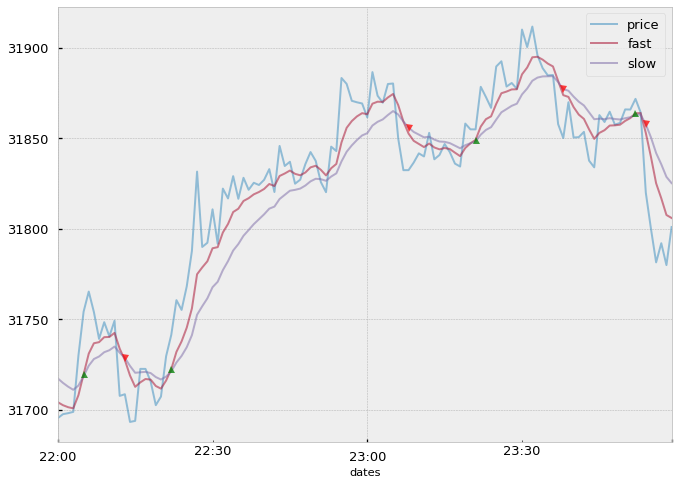

In [66]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1)&(crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.slow[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2022-05-31 22:00:00':].plot(ax=ax,alpha=.5)
up.loc['2022-05-31 22:00:00':].plot(ax=ax,
                     ls='',
                     marker='^',
                     markersize=7,
                     alpha=.75,
                     label='upcross',
                     color = 'g')
down.loc['2022-05-31 22:00:00':].plot(ax=ax,
                     ls='',
                     marker='v',
                     markersize=7,
                     alpha=.75,
                     label='downcross',
                     color = 'r')


In [67]:
# trading signal
side_up = pd.Series(1,index = up.index)
side_down = pd.Series(-1, index = down.index)
side = pd.concat([side_up, side_down]).sort_index()
cprint(side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
dates                 
2022-05-31 23:08:00 -1
2022-05-31 23:21:00  1
2022-05-31 23:38:00 -1
2022-05-31 23:52:00  1
2022-05-31 23:54:00 -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163317 entries, 2017-08-17 04:04:00 to 2022-05-31 23:54:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       163317 non-null  int64
dtypes: int64(1)
memory usage: 2.5 MB
None
-------------------------------------------------------------------------------



In [83]:
minRet = .001
ptSl = [1,2]
ma_events = getEvents(close, side['2017-08-18 03:48:00':].index, ptSl, target, minRet, cpus, t1 = t1, side = side)
cprint(ma_events)

DatetimeIndex(['2017-08-18 10:01:00', '2017-08-18 10:06:00',
               '2017-08-18 10:09:00', '2017-08-18 10:48:00',
               '2017-08-18 10:55:00', '2017-08-18 11:14:00',
               '2017-08-18 11:40:00', '2017-08-18 11:45:00',
               '2017-08-18 11:50:00', '2017-08-18 12:06:00',
               ...
               '2022-05-31 21:33:00', '2022-05-31 21:43:00',
               '2022-05-31 22:05:00', '2022-05-31 22:13:00',
               '2022-05-31 22:22:00', '2022-05-31 23:08:00',
               '2022-05-31 23:21:00', '2022-05-31 23:38:00',
               '2022-05-31 23:52:00', '2022-05-31 23:54:00'],
              dtype='datetime64[ns]', name='dates', length=163198, freq=None)


2022-10-23 19:15:00.087108 100.0% applyPtSlOnT1 done after 11.2 minutes. Remaining 0.0 minutes.s.


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     t1      trgt  side
2022-05-31 23:08:00 NaT  0.006838  -1.0
2022-05-31 23:21:00 NaT  0.006473   1.0
2022-05-31 23:38:00 NaT  0.005505  -1.0
2022-05-31 23:52:00 NaT  0.004797   1.0
2022-05-31 23:54:00 NaT  0.004705  -1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161027 entries, 2017-08-18 04:04:00 to 2022-05-31 23:54:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   t1      161002 non-null  datetime64[ns]
 1   trgt    161027 non-null  float64       
 2   side    161027 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.9 MB
None
-------------------------------------------------------------------------------



In [84]:
ma_events.side.value_counts()

-1.0    80516
 1.0    80511
Name: side, dtype: int64

In [85]:
ma_side= ma_events.dropna().side

In [86]:
ma_bins = getBins(ma_events,close).dropna()

In [96]:
cprint(ma_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2022-05-31 17:38:00  0.006235  1.0
2022-05-31 17:47:00 -0.012368  0.0
2022-05-31 18:21:00  0.005223  1.0
2022-05-31 20:01:00  0.005489  1.0
2022-05-31 20:12:00  0.005198  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161002 entries, 2017-08-18 04:04:00 to 2022-05-31 20:12:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ret     161002 non-null  float64
 1   bin     161002 non-null  float64
dtypes: float64(2)
memory usage: 3.7 MB
None
-------------------------------------------------------------------------------



In [88]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns = {0:'side'}),
                   left_index = True, right_index = True, direction = 'forward')

In [89]:
Xx.ret.sum()

13.186260443308289

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [91]:
X = ma_side.values.reshape(-1,1)
y = ma_bins.bin.values
pd.DataFrame(X,y)

,0
1.0,-1.0
0.0,1.0
0.0,-1.0
1.0,1.0
0.0,-1.0
...,...
1.0,-1.0
0.0,1.0
1.0,-1.0
1.0,1.0


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, shuffle = False)

In [93]:
n_estimator = 777
rf = RandomForestClassifier(max_depth = 2, n_estimators=n_estimator,
                            criterion = 'entropy', random_state = RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=777,
                       random_state=777)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     27548
         1.0       0.66      1.00      0.79     52953

    accuracy                           0.66     80501
   macro avg       0.33      0.50      0.40     80501
weighted avg       0.43      0.66      0.52     80501



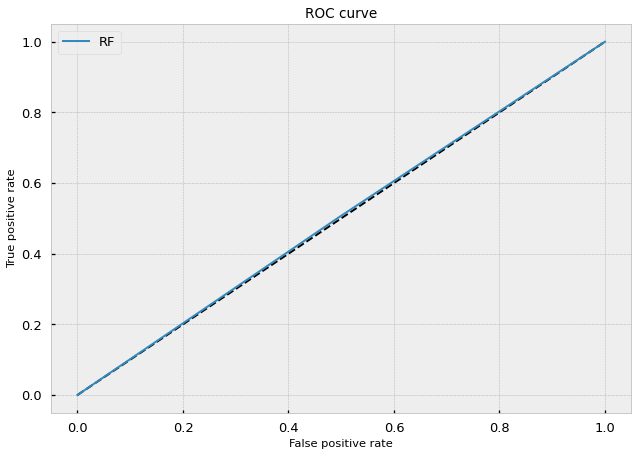

In [94]:
# The random forest model by itself

y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
      
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()